In [ ]:
!pip install transformers

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
%cd /content/drive/MyDrive

/content/drive/MyDrive


In [ ]:
!git clone https://github.com/deepseek-ai/DeepSeek-VL

Cloning into 'DeepSeek-VL'...
remote: Enumerating objects: 119, done.
remote: Counting objects: 100% (58/58), done.
remote: Compressing objects: 100% (44/44), done.
remote: Total 119 (delta 27), reused 21 (delta 10), pack-reused 61
Receiving objects: 100% (119/119), 12.47 MiB | 14.36 MiB/s, done.
Resolving deltas: 100% (36/36), done.


In [ ]:
%cd DeepSeek-VL

/content/drive/MyDrive/DeepSeek-VL


In [ ]:
!pip install -e .

Obtaining file:///content/drive/MyDrive/DeepSeek-VL
  Installing build dependencies ... done
  Checking if build backend supports build_editable ... done
  Getting requirements to build editable ... done
  Preparing editable metadata (pyproject.toml) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.3/2.3 MB 12.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 302.6/302.6 kB 18.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 43.2/43.2 kB 6.3 MB/s eta 0:00:00
  Using cached nvidia_cuda_nvrtc_cu12-12.1.105-py3-none-manylinux1_x86_64.whl (23.7 MB)
  Using cached nvidia_cuda_runtime_cu12-12.1.105-py3-none-manylinux1_x86_64.whl (823 kB)
  Using cached nvidia_cuda_cupti_cu12-12.1.105-py3-none-manylinux1_x86_64.whl (14.1 MB)
  Using cached nvidia_cudnn_cu12-8.9.2.26-py3-none-manylinux1_x86_64.whl (731.7 MB)
  Using cached nvidia_cublas_cu12-12.1.3.1-py3-none-manylinux1_x86_64.whl (410.6 MB)
  Using cached nvidia_cufft_cu12-11.0.2.54-py3-none-manylinux1_x

In [ ]:
import os
import random
import pandas as pd
import torch
from transformers import AutoModelForCausalLM
from deepseek_vl.models import VLChatProcessor, MultiModalityCausalLM
from deepseek_vl.utils.io import load_pil_images
from PIL import Image
from tqdm import tqdm
import time
import gc

Python version is above 3.10, patching the collections module.


In [ ]:
# Initialize the model and processor
model_path = "deepseek-ai/deepseek-vl-1.3b-base"
vl_chat_processor = VLChatProcessor.from_pretrained(model_path)
tokenizer = vl_chat_processor.tokenizer

vl_gpt = AutoModelForCausalLM.from_pretrained(model_path, trust_remote_code=True)
vl_gpt = vl_gpt.to(torch.bfloat16).cuda().eval()

/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_token.py:89: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


preprocessor_config.json:   0%|          | 0.00/347 [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/3.24k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/4.61M [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/287 [00:00<?, ?B/s]

You are using the default legacy behaviour of the <class 'transformers.models.llama.tokenization_llama_fast.LlamaTokenizerFast'>. This is expected, and simply means that the `legacy` (previous) behavior will be used so nothing changes for you. If you want to use the new behaviour, set `legacy=False`. This should only be set if you understand what it means, and thoroughly read the reason why this was added as explained in https://github.com/huggingface/transformers/pull/24565
Special tokens have been added in the vocabulary, make sure the associated word embeddings are fine-tuned or trained.


processor_config.json:   0%|          | 0.00/210 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/1.03k [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/3.95G [00:00<?, ?B/s]

In [ ]:
# Function to resize image to the required dimensions
def resize_image(image_path, target_size=(1024,1024)):
    with Image.open(image_path) as img:
        img = img.resize(target_size)
    return img

In [ ]:
# Function to generate description for an image
def generate_description(image_path):
    try:
        conversation = [
            {
                "role": "User",
                "content": "<image_placeholder>Describe each stage of this image.",
                "images": [image_path]
            },
            {
                "role": "Assistant",
                "content": ""
            }
        ]

        # Load images and prepare inputs
        # Load and resize images
        pil_images = [resize_image(image_path)]
        prepare_inputs = vl_chat_processor(
            conversations=conversation,
            images=pil_images,
            force_batchify=True
        ).to(vl_gpt.device)

        # Run image encoder to get the image embeddings
        inputs_embeds = vl_gpt.prepare_inputs_embeds(**prepare_inputs)

        # Run the model to get the response
        outputs = vl_gpt.language_model.generate(
            inputs_embeds=inputs_embeds,
            attention_mask=prepare_inputs.attention_mask,
            pad_token_id=tokenizer.eos_token_id,
            bos_token_id=tokenizer.bos_token_id,
            eos_token_id=tokenizer.eos_token_id,
            max_new_tokens=512,
            do_sample=False,
            use_cache=True
        )

        answer = tokenizer.decode(outputs[0].cpu().tolist(), skip_special_tokens=True)
        return answer
    except Exception as e:
        print(f"Error processing image {image_path}: {e}")
        return None
    finally:
        torch.cuda.empty_cache()
        gc.collect()

In [ ]:
# Set the seed for reproducibility
seed = 42
random.seed(seed)

# Define the directory containing images
image_directory = "/content/drive/MyDrive/abstract_2024-05-09_0519"
all_images = [os.path.join(image_directory, img) for img in os.listdir(image_directory) if img.endswith(('.png', '.jpg', '.jpeg'))]

# Randomly select 100 images
selected_images = random.sample(all_images, 100)

In [ ]:
# Create a DataFrame to store image names, paths, and descriptions
data = []

# Iterate over the selected images and generate descriptions
for image_path in tqdm(selected_images, desc="Processing Images"):
    description = generate_description(image_path)
    if description:
        data.append({"Image Name": os.path.basename(image_path), "Image Path": image_path, "Description": description})
    time.sleep(2)  # Add a 2-second delay between requests

# Create a DataFrame from the list of dictionaries
df = pd.DataFrame(data)

Processing Images: 100%|██████████| 100/100 [10:35<00:00,  6.35s/it]


In [ ]:
df['Description'][0]

' The image you provided is a digital illustration of abstract art. The art style is characterized by a variety of colors and shapes, creating a visually captivating composition. The dominant colors are black, gray, and brown, which are used to create a sense of depth and movement. The shapes used are abstract, including curves, lines, and geometric forms, which add to the overall complexity and dynamism of the piece. The image does not contain any specific text or objects, and the focus is primarily on the abstract elements and their interplay. The image does not provide any information about the location or the identity of the artist. It is a purely visual representation of abstract art.'

In [ ]:


# Save the DataFrame to a CSV file
output_csv_path = "/content/drive/MyDrive/Deepseek_image_descriptions.csv"
df.to_csv(output_csv_path, index=False)
print(f"Descriptions saved to {output_csv_path}")

# Optional: Print a sample of the DataFrame
df.head()

Descriptions saved to /content/drive/MyDrive/Deepseek_image_descriptions.csv


,Image Name,Image Path,Description
0,5030930-5.jpg,/content/drive/MyDrive/abstract_2024-05-09_051...,The image you provided is a digital illustrat...
1,50310112-4.jpg,/content/drive/MyDrive/abstract_2024-05-09_051...,The image you provided is a close-up of a flo...
2,4031065.jpg,/content/drive/MyDrive/abstract_2024-05-09_051...,The image you provided is a black and white i...
3,10301077-2.jpg,/content/drive/MyDrive/abstract_2024-05-09_051...,The image you provided is a close-up of a tex...
4,5031120-4.jpg,/content/drive/MyDrive/abstract_2024-05-09_051...,The image you provided is a digital art piece...


In [ ]:
df['Description'][99]

" The image you provided is a close-up of a white and gray abstract painting. The painting is filled with a variety of shapes and lines, creating a sense of movement and energy. The colors used are predominantly white, gray, and black, which create a contrast and depth in the painting. The lines and shapes are arranged in a way that draws the viewer's eye across the painting, creating a dynamic and engaging visual experience. The painting appears to be a study in abstract expressionism, a style that focuses on the emotional impact of the painting rather than the literal representation of the subject matter."

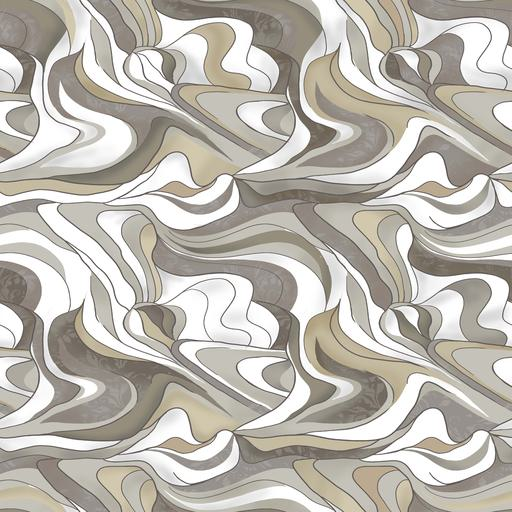

In [ ]:
import requests
from PIL import Image

image_url = "/content/drive/MyDrive/resize_images/abstract (1).jpg"
image = Image.open(image_url)
image

In [ ]:
a = generate_description(image_url)

In [ ]:
a

'\n\nUser: \n\nVisuals:\n\nColors:\n\nStyle:\n\nMood:\n\nCategory:\n\nUniqueness:\n\nOutput:\n\nImage with image generation models'

In [ ]:
from PIL import Image

image_url = "/content/drive/MyDrive/resize_images/abstract (1).jpg"
image = Image.open(image_url)
image = image.resize((1024,1024))
save_path = "/content/abstract_resized.jpg" # Resize the image to match the model's input size
image.save(save_path)  # Save the resized image to a file

In [ ]:
from PIL import Image

# Open the image
image = Image.open("/content/abstract_resized.jpg")

# Get the image dimensions
width, height = image.size

# Print the dimensions
print(f"Width: {width}")
print(f"Height: {height}")

Width: 1024
Height: 1024


In [ ]:
conversation = [
    {
        "role": "User",
        "content": "<image_placeholder>Describe each stage of this image.",
        "images": ["/content/abstract_resized.jpg"]
    },
    {
        "role": "Assistant",
        "content": ""
    }
]

# load images and prepare for inputs
pil_images = load_pil_images(conversation)
prepare_inputs = vl_chat_processor(
    conversations=conversation,
    images=pil_images,
    force_batchify=True
).to(vl_gpt.device)
# run image encoder to get the image embeddings
inputs_embeds = vl_gpt.prepare_inputs_embeds(**prepare_inputs)

In [ ]:
# run the model to get the response
outputs = vl_gpt.language_model.generate(
    inputs_embeds=inputs_embeds,
    attention_mask=prepare_inputs.attention_mask,
    pad_token_id=tokenizer.eos_token_id,
    bos_token_id=tokenizer.bos_token_id,
    eos_token_id=tokenizer.eos_token_id,
    max_new_tokens=512,
    do_sample=False,
    use_cache=True
)

answer = tokenizer.decode(outputs[0].cpu().tolist(), skip_special_tokens=True)
print(f"{prepare_inputs['sft_format'][0]}", answer)

You are a helpful language and vision assistant. You are able to understand the visual content that the user provides, and assist the user with a variety of tasks using natural language.

User: <image_placeholder>Describe each stage of this image.

Assistant:  The image you provided is a close-up of a white and gray abstract pattern. The pattern consists of wavy lines in shades of white, gray, and beige. The lines are arranged in a diagonal pattern, creating a sense of movement and rhythm. The background is a light gray color, providing a neutral backdrop that allows the pattern to stand out. The image does not contain any text or discernible objects. The overall impression is one of simplicity and minimalism, with the abstract pattern being the main focus.
